# Predicting babyweight using BigQuery ML

This notebook illustrates:
<ol>
<li> Machine Learning using BigQuery
<li> Jupyter Magic for BigQuery in Cloud Datalab
</ol>

Please see [this notebook](1_explore.ipynb) for more context on this problem and how the features were chosen.

In [1]:
import os
output = os.popen("gcloud config get-value project").readlines()
project_name = output[0][:-1]

# change these to try this notebook out
PROJECT = project_name
BUCKET = project_name
BUCKET = BUCKET.replace("qwiklabs-gcp-", "inna-bckt-")
REGION = 'europe-west1'  ## note: Cloud ML Engine not availabe in europe-west3!

print(PROJECT)
print(BUCKET)
print("gsutil mb -l {0} gs://{1}".format(REGION, BUCKET))

## set config for gcp config: [[?]]
print(os.popen("gcloud config set project $PROJECT").readlines())
print(os.popen("gcloud config set compute/region $REGION").readlines())

qwiklabs-gcp-3d4d05890366c909
inna-bckt-3d4d05890366c909
gsutil mb -l europe-west1 gs://inna-bckt-3d4d05890366c909
[]
[]


In [2]:
import os
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Exploring the Data

Here, we will be taking natality data and training on features to predict the birth weight.

The CDC's Natality data has details on US births from 1969 to 2008 and is available in BigQuery as a public data set. More details: https://bigquery.cloud.google.com/table/publicdata:samples.natality?tab=details

Lets start by looking at the data since 2000 with useful values > 0!

In [4]:
%%bq query
SELECT
    *
FROM
  publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

source_year,year,month,day,wday,state,is_male,child_race,weight_pounds,plurality,apgar_1min,apgar_5min,mother_residence_state,mother_race,mother_age,gestation_weeks,lmp,mother_married,mother_birth_state,cigarette_use,cigarettes_per_day,alcohol_use,drinks_per_week,weight_gain_pounds,born_alive_alive,born_alive_dead,born_dead,ever_born,father_race,father_age,record_weight
2001,2001,6,,3,AZ,False,9,4.6958461806,1,99,3,AZ,1,31,32,99999999,True,Mexico,,,False,,20,2,0,0,3,1,45,1
2001,2001,12,,5,CT,True,9,5.6879263596,1,99,9,CT,1,30,36,03272001,True,CT,,,False,,20,0,0,0,1,1,42,1
2001,2001,4,,2,OR,False,9,7.06140625186,1,99,9,OR,1,40,37,08072000,True,NY,,,False,,21,0,0,0,1,1,42,1
2001,2001,9,,3,TN,False,9,7.5618555866,1,99,9,TN,1,20,43,11152000,True,TN,,,False,,52,0,0,0,1,1,24,1
2001,2001,10,,1,CA,False,9,8.062304921339999,1,99,99,CA,1,33,39,01192001,True,Mexico,,,,,99,0,0,0,1,1,31,1
2001,2001,3,,2,VA,False,9,7.9586876582,1,99,9,VA,2,24,39,06162000,False,VA,,,False,,35,1,0,0,2,2,22,1
2001,2001,6,,2,OH,True,9,8.19899152378,1,99,9,OH,1,29,39,09162000,True,OH,,,False,,30,1,0,1,2,1,29,1
2001,2001,7,,6,PA,False,9,6.686620406459999,1,99,9,PA,1,31,42,09992000,True,PA,,,False,,41,0,0,1,1,9,29,1
2001,2001,8,,7,IL,False,9,7.936641432,1,99,9,IL,2,24,39,11152000,False,IL,,,False,,50,3,0,1,4,2,23,1
2001,2001,3,,6,MO,True,9,5.4454178714,1,99,8,MO,2,30,35,07162000,False,MO,,,False,,17,3,0,1,4,9,99,1


## Define Features

Looking over the data set, there are a few columns of interest that could be leveraged into features for a reasonable prediction of approximate birth weight.

Further, some feature engineering may be accomplished with the BigQuery `CAST` function -- in BQML, all strings are considered categorical features and all numeric types are considered continuous ones.

The hashmonth is added so that we can repeatably split the data without leakage -- we want all babies that share a birthday to be either in training set or in test set and not spread between them (otherwise, there would be information leakage when it comes to triplets, etc.)

In [5]:
%%bq query
SELECT
    weight_pounds, -- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE
  year > 2000
  AND gestation_weeks > 0
  AND mother_age > 0
  AND plurality > 0
  AND weight_pounds > 0
LIMIT 10

weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
7.56846945446,true,22,1,46,1403073183891835564
8.8074673669,true,39,1,42,1088037545023002395
8.313631900019999,true,23,1,35,2126480030009879160
7.3524164377,true,30,1,37,8904940584331855459
8.062304921339999,true,16,1,40,2126480030009879160
7.25100379718,true,17,1,39,1525201076796226340
8.000575487979999,false,27,1,40,7170969733900686954
6.56316153974,false,29,1,39,3408502330831153141
7.12534030784,false,34,1,40,7108882242435606404
7.43839671988,false,31,1,38,6392072535155213407


## Train Model

With the relevant columns chosen to accomplish predictions, it is then possible to create (train) the model in BigQuery. First, a dataset will be needed store the model. (if this throws an error in Datalab, simply create the dataset from the BigQuery console).

In [6]:
%%bash
bq --location=US mk -d demo

Dataset 'qwiklabs-gcp-3d4d05890366c909:demo' successfully created.


With the demo dataset ready, it is possible to create a linear regression model to train the model.

This will take approximately **4 minutes** to run and will show **Done** when complete.

In [7]:
%%bq query
CREATE or REPLACE MODEL demo.babyweight_model_asis
OPTIONS
  (model_type='linear_reg', labels=['weight_pounds']) AS
  
WITH natality_data AS (
  SELECT
    weight_pounds,-- this is the label; because it is continuous, we need to use regression
    CAST(is_male AS STRING) AS is_male,
    mother_age,
    CAST(plurality AS STRING) AS plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    natality_data
WHERE
  MOD(hashmonth, 4) < 3  -- select 75% of the data as training

QueryResultsTable job_Ky8BgpwMpOuIDEv-Ig1cyGs-zcrd

## Training Statistics

During the model training (and after the training), it is possible to see the model's training evaluation statistics.

For each training run, a table named `<model_name>_eval` is created. This table has basic performance statistics for each iteration.

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://bigquery.cloud.google.com/

Since these statistics are updated after each iteration of model training, you will see different values for each refresh while the model is training.

The training details may also be viewed after the training completes from this notebook.

In [8]:
%%bq query
SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis);

training_run,iteration,loss,eval_loss,duration_ms,learning_rate
0,5,1.130778705382134,1.130046666449312,48042,0.4
0,4,1.1323796236826644,1.1316356800041987,45534,0.8
0,3,1.1435126061390204,1.14392691917879,46508,0.4
0,2,1.1790187708132924,1.1794707158388003,46536,0.4
0,1,1.5728334458954585,1.5763131281774705,43742,0.4
0,0,9.85574526059515,9.846955904529489,22935,0.2


Some of these columns are obvious although what do the non-specific ML columns mean (specific to BQML)?

**training_run** - Will be zero for a newly created model. If the model is re-trained using warm_start, this will increment for each re-training.

**iteration** - Number of the associated `training_run`, starting with zero for the first iteration.

**duration_ms** - Indicates how long the iteration took (in ms).

Note: You can also see these stats by refreshing the BigQuery UI window, finding the `<model_name>` table, selecting on it, and then the Training Stats sub-header.

Let's plot the training and evaluation loss to see if the model has an overfit.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


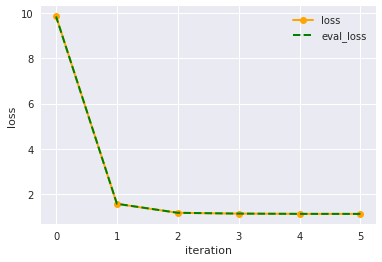

In [9]:
import google.datalab.bigquery as bq
df = bq.Query("SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_asis)").execute().result().to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
plt.plot( 'iteration', 'loss', data=df, marker='o', color='orange', linewidth=2)
plt.plot( 'iteration', 'eval_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

As you can see, the training loss and evaluation loss are essentially identical. We do not seem to be overfitting.

## Make a Prediction with BQML using the Model

With a trained model, it is now possible to make a prediction on the values. The only difference from the second query above is the reference to the model. The data has been limited (`LIMIT 100`) to reduce amount of data returned.

When the `ml.predict` function is leveraged, output prediction column name for the model is `predicted_<label_column_name>`.

In [10]:
%%bq query
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_asis,
      (SELECT
        weight_pounds,
        CAST(is_male AS STRING) AS is_male,
        mother_age,
        CAST(plurality AS STRING) AS plurality,
        gestation_weeks
      FROM
        publicdata.samples.natality
      WHERE
        year > 2000
        AND gestation_weeks > 0
        AND mother_age > 0
        AND plurality > 0
        AND weight_pounds > 0
    ))
LIMIT 100

predicted_weight_pounds,weight_pounds,is_male,mother_age,plurality,gestation_weeks
7.487098841176108,6.9996768185,true,14,1,40
9.07397697179384,6.87621795178,true,17,1,46
7.824733299490909,7.43839671988,true,18,1,41
7.591605655288268,7.31273323054,true,19,1,40
7.104449004060555,6.6248909731,true,20,1,38
7.104449004060555,8.3114272774,true,20,1,38
6.596390990010411,6.4992274837599995,true,20,1,36
7.104449004060555,3.87572656596,true,20,1,38
8.120565032160846,8.157103694,true,20,1,42
7.358478011085628,7.06361087448,true,20,1,39


In [13]:
%%bq query
select
  *
from 
  ml.EVALUATE(MODEL demo.babyweight_model_asis, 
              (
                -- select features from test_data 
SELECT
        weight_pounds,
        CAST(is_male AS STRING) AS is_male,
        mother_age,
        CAST(plurality AS STRING) AS plurality,
        gestation_weeks
      FROM
        publicdata.samples.natality
      WHERE
        year > 2000
        AND gestation_weeks > 0
        AND mother_age > 0
        AND plurality > 0
        AND weight_pounds > 0
))

mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0.8258431758791801,1.1306742442324702,0.020461737872562672,0.6708628314323581,0.35068052089691604,0.35070166961408966


In [14]:
import google.datalab.bigquery as bq
query = """
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_asis,
      (SELECT
        weight_pounds,
        CAST(is_male AS STRING) AS is_male,
        mother_age,
        CAST(plurality AS STRING) AS plurality,
        gestation_weeks
      FROM
        publicdata.samples.natality
      WHERE
        year > 2000
        AND gestation_weeks > 0
        AND mother_age > 0
        AND plurality > 0
        AND weight_pounds > 0
    ))
LIMIT 1000
"""
dat_pred = bq.Query(query).execute().result().to_dataframe()
dat_pred.head(n = 5)


,predicted_weight_pounds,weight_pounds,is_male,mother_age,plurality,gestation_weeks
0,6.958139,6.624891,true,13,1,38
1,7.456008,8.000575,false,13,1,41
2,7.487099,6.999677,true,14,1,40
3,6.714822,6.501432,false,14,1,38
4,7.243781,8.187968,false,15,1,40


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

varname_y_true = "predicted_weight_pounds"
varname_y_pred = "weight_pounds"
y_true = dat_pred[varname_y_true]
y_pred = dat_pred[varname_y_pred]
print("pandas correlation matrix (squared) = ")
print(dat_pred[[varname_y_true, varname_y_pred]].corr() ** 2)
print()
print("numpy correlation matrix (squared) = ")
print(np.corrcoef(y_true, y_pred) ** 2)
print()
print("mean_squared_error(y_true, y_pred) = ", mean_squared_error(y_true, y_pred))
print("mse (manual) = ", np.mean((y_true - y_pred) ** 2) )
print("mean_absolute_error(y_true, y_pred) = ", mean_absolute_error(y_true, y_pred))
print("mae (manual) = ", np.mean(np.abs(y_true - y_pred)))
print("r2score = ", r2_score(y_true, y_pred), " -- why?!? [[?]]")
print("type(y_true) = ", type(y_true))
print("type(y_pred) = ", type(y_pred))
print()
print("r2score = ", r2_score(y_true.values, y_pred.values), " -- why?!? [[?]]")
print("type(y_true.values) = ", type(y_true.values))
print(y_true[:2])
print(y_pred[:2])


pandas correlation matrix (squared) = 
                         predicted_weight_pounds  weight_pounds
predicted_weight_pounds                 1.000000       0.267188
weight_pounds                           0.267188       1.000000

numpy correlation matrix (squared) = 
[[1.         0.26718804]
 [0.26718804 1.        ]]

mean_squared_error(y_true, y_pred) =  1.2107178688211921
mse (manual) =  1.2107178688211921
mean_absolute_error(y_true, y_pred) =  0.8463800654696979
mae (manual) =  0.8463800654696979
r2score =  -1.3744345157127085  -- why?!? [[?]]
type(y_true) =  <class 'pandas.core.series.Series'>
type(y_pred) =  <class 'pandas.core.series.Series'>

r2score =  -1.3744345157127085  -- why?!? [[?]]
type(y_true.values) =  <class 'numpy.ndarray'>
0    6.958139
1    7.456008
Name: predicted_weight_pounds, dtype: float64
0    6.624891
1    8.000575
Name: weight_pounds, dtype: float64


# More advanced...

In the original example, we were taking into account the idea that if no ultrasound has been performed, some of the features (e.g. is_male) will not be known. Therefore, we augmented the dataset with such masked features and trained a single model to deal with both these scenarios.

In addition, during data exploration, we learned that the data size set for mothers older than 45 was quite sparse, so we will discretize the mother age.

In [29]:
%%bq query
SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
LIMIT 25

weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
8.8074673669,true,39,1,42,1088037545023002395
7.3744626639,true,38,1,38,1088037545023002395
8.1350574678,true,20,1,39,6244544205302024223
7.25100379718,true,LOW,1,39,1525201076796226340
6.25671899556,true,29,1,41,7146494315947640619
7.62578964258,true,22,1,41,6392072535155213407
7.3524164377,true,30,1,37,8904940584331855459
9.0940683075,true,25,1,40,8904940584331855459
7.87491199864,true,36,1,39,7170969733900686954
7.5618555866,true,27,1,39,6691862025345277042


On the same dataset, will also suppose that it is unknown whether the child is male or female (on the same dataset) to simulate that an ultrasound was not been performed.

In [30]:
%%bq query
SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
LIMIT 25

weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
9.259415004,Unknown,28,Single,38,1088037545023002395
8.062304921339999,Unknown,19,Single,39,1088037545023002395
9.37405538024,Unknown,29,Single,41,1088037545023002395
7.06361087448,Unknown,18,Single,40,1525201076796226340
7.50012615324,Unknown,31,Single,44,1525201076796226340
6.2501051276999995,Unknown,23,Single,41,1525201076796226340
7.12534030784,Unknown,34,Single,39,7146494315947640619
3.99918543268,Unknown,30,Single,32,7146494315947640619
7.94105067724,Unknown,33,Single,41,7146494315947640619
7.43839671988,Unknown,LOW,Single,34,7146494315947640619


Bringing these two separate data sets together, there is now a dataset for male or female children determined with ultrasound or unknown if without. 

In [31]:
%%bq query
WITH with_ultrasound AS (
  SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

without_ultrasound AS (
  SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

preprocessed AS (
  SELECT * from with_ultrasound
  UNION ALL
  SELECT * from without_ultrasound
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    preprocessed
WHERE
  MOD(hashmonth, 4) < 3
LIMIT 25

weight_pounds,is_male,mother_age,plurality,gestation_weeks
3.62439958728,Unknown,26,Single,25
4.46877005074,Unknown,24,Single,33
4.2108292041999995,Unknown,23,Single,33
8.313631900019999,Unknown,23,Single,35
7.0592016292399995,Unknown,24,Single,35
6.0627122049999995,Unknown,28,Single,36
9.81277528162,Unknown,27,Single,38
6.56316153974,Unknown,29,Single,39
7.25100379718,Unknown,LOW,Single,39
7.5618555866,Unknown,27,Single,39


## Create a new model

With a data set which has been feature engineered, it is ready to create model with the `CREATE or REPLACE MODEL` statement

This will take **5-10 minutes** and will show **Done** when complete.

In [32]:
%%bq query
CREATE or REPLACE MODEL demo.babyweight_model_fc
OPTIONS
  (model_type='linear_reg', labels=['weight_pounds']) AS
  
WITH with_ultrasound AS (
  SELECT
    weight_pounds,
    CAST(is_male AS STRING) AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    CAST(plurality AS STRING) AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

without_ultrasound AS (
  SELECT
    weight_pounds,
    'Unknown' AS is_male,
    IF(mother_age < 18, 'LOW',
         IF(mother_age > 45, 'HIGH',
            CAST(mother_age AS STRING))) AS mother_age,
    IF(plurality > 1, 'Multiple', 'Single') AS plurality,
    CAST(gestation_weeks AS STRING) AS gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
  FROM
    publicdata.samples.natality
  WHERE
    year > 2000
    AND gestation_weeks > 0
    AND mother_age > 0
    AND plurality > 0
    AND weight_pounds > 0
),

preprocessed AS (
  SELECT * from with_ultrasound
  UNION ALL
  SELECT * from without_ultrasound
)

SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks
FROM
    preprocessed
WHERE
  MOD(hashmonth, 4) < 3

QueryResultsTable job_UUXwBQrhMcpCAOaQ-399GxwAWjhV

## Training Statistics

While the new model is training, review the training statistics in the BigQuery UI to see the below model training: https://bigquery.cloud.google.com/

The training details may also be viewed after the training completes from this notebook.

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


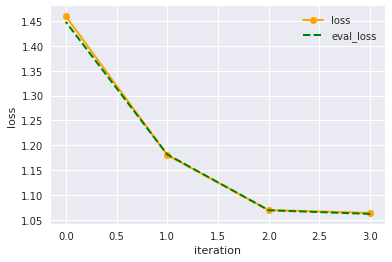

In [33]:
import google.datalab.bigquery as bq
df = bq.Query("SELECT * FROM ML.TRAINING_INFO(MODEL demo.babyweight_model_fc)").execute().result().to_dataframe()
# plot both lines in same graph
import matplotlib.pyplot as plt
plt.plot( 'iteration', 'loss', data=df, marker='o', color='orange', linewidth=2)
plt.plot( 'iteration', 'eval_loss', data=df, marker='', color='green', linewidth=2, linestyle='dashed')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend();

## Make a prediction with the new model



Perhaps it is of interest to make a prediction of the baby's weight given a number of other factors: Male, Mother is 28 years old, Mother will only have one child, and the baby was born after 38 weeks of pregnancy.

To make this prediction, these values will be passed into the SELECT statement.

In [34]:
%%bq query
SELECT
  *
FROM
  ml.PREDICT(MODEL demo.babyweight_model_fc,
      (SELECT
          'True' AS is_male,
          '28' AS mother_age,
          '1' AS plurality,
          '38' AS gestation_weeks
    ))

predicted_weight_pounds,is_male,mother_age,plurality,gestation_weeks
5.856195578319181,True,28,1,38


## Not Tested:

In [ ]:
%%bq query
select
  roc_auc,
  accuracy,
  precision,
  recall
from 
  ml.EVALUATE(MODEL demo.babyweight_model_fc, 
              (
                -- select features from test_data 
                -- (SQL-Query with test data)
              ))

<br>
<br>
<br>
<br>
Copyright 2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License